In [43]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import shap

pd.set_option('display.max_colwidth', None)

In [2]:
train_df = pd.read_csv("data/train.csv", encoding="utf-8")
eval_df = pd.read_csv("data/eval.csv", encoding="utf-8")

In [3]:
train_df.info()
print()
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  800 non-null    int64  
 1   comment     800 non-null    object 
 2   rate        800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   comment     200 non-null    object 
 2   rate        200 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


In [4]:
train_df.head(10)

,Unnamed: 0,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هسته ای با توان ساختن دو هسته‌ی مجازی دیگر هستند.,0.00
1,22591,سلام به دوستای عزیزم \r\nعزاداری هاتون قبول باشه,1.00
2,141037,کلا پولتون رو دور نریزیزد,-1.00
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پوریا رو فراموش کنه,1.00
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراحی فوق العاده است، که البته ادعایی غیر واقعی نیست.,1.00
5,168940,در کل کفش بدی نیست ولی من خودم دادشتم دور دوخت ولی با این قیمت این کفش ارزش خرید نداره,0.68
6,6751,به دلیل وجود پنل IPS بر روی این صفحه نمایش، عملکرد آن در زوایای مختلف نیز بسیار مناسب و قابل قبول است.,1.00
7,43698,همکارم این دانگل رو خریده بود و بعد از گذشت حدود 10 روز استفاده میگفت که بسیار دانگل خوبی است. لگ ندارد. افت کیفیت ندارد. برد خوبی دارد در حد 5 متر، خیلی راحت متصل میشود و داغ نمیکند.\r\nدر شگفت انگیز ارزش خرید بالایی دارد. \r\nدیجی جان شگفت انگیزش کن من و چندتا دوستان میخوایم خرید کنیم.,0.20
8,34297,چقد فاصله داریم!!!,1.00
9,161474,خیلی زود شارژ خالی میکنه,0.82


In [5]:
# check missing values
train_df.isna().mean()

Unnamed: 0    0.0
comment       0.0
rate          0.0
dtype: float64

Text(0.5, 0, 'Number of rates')

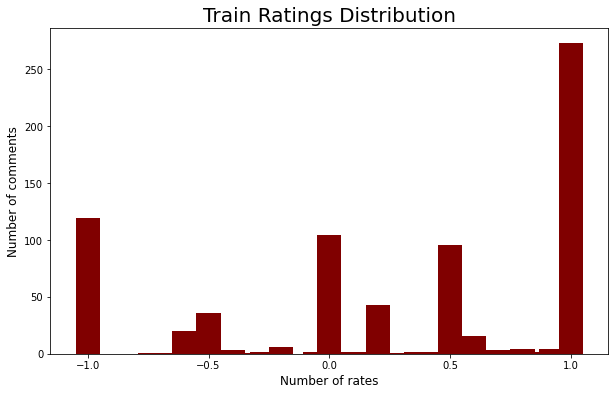

In [6]:
rates_count = train_df['rate'].value_counts()
rates_count = rates_count.sort_index()

fig = plt.figure(figsize=(10, 6))
plt.bar(rates_count.index, rates_count.values, color ='maroon', width=0.1)
plt.title("Train Ratings Distribution", fontsize = 20)
plt.ylabel('Number of comments', fontsize = 12)
plt.xlabel('Number of rates', fontsize = 12)

In [7]:
# convert rate to 1 and -1 for binary classification
train_df.loc[train_df['rate'] >= 0, 'rate'] = 1
train_df.loc[train_df['rate'] < 0, 'rate'] = 0

eval_df.loc[eval_df['rate'] >= 0, 'rate'] = 1
eval_df.loc[eval_df['rate'] < 0, 'rate'] = 0

Text(0.5, 0, 'Number of rates')

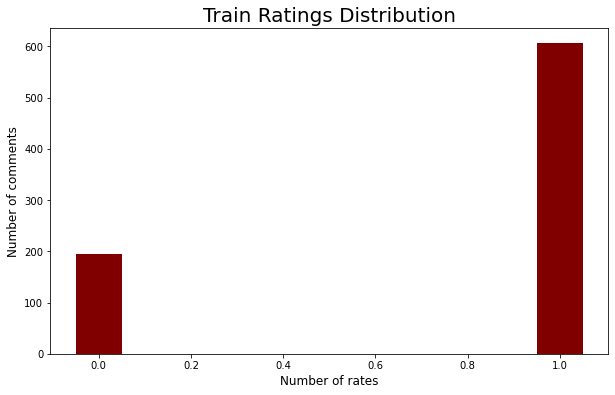

In [8]:
rates_count = train_df['rate'].value_counts()
rates_count = rates_count.sort_index()

fig = plt.figure(figsize=(10, 6))
plt.bar(rates_count.index, rates_count.values, color ='maroon', width=0.1)
plt.title("Train Ratings Distribution", fontsize = 20)
plt.ylabel('Number of comments', fontsize = 12)
plt.xlabel('Number of rates', fontsize = 12)

In [9]:
# baseline
print("Baseline Accuracy: {:.2f}".format(train_df[train_df.rate == 1].shape[0]/train_df.shape[0]))

Baseline Accuracy: 0.76


In [10]:
y_train = train_df['rate'].values
y_test = eval_df['rate'].values

In [35]:
start_time = time.time()
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train_df['comment'].values)

<800x275 sparse matrix of type '<class 'numpy.int64'>'
	with 7848 stored elements in Compressed Sparse Row format>

In [36]:
start_time = time.time()
tfidf_v = TfidfVectorizer(use_idf=True, min_df = 10, max_df = 0.95)
tfidf_v.fit_transform(train_df['comment'].values)
train_feature_set = tfidf_v.transform(train_df['comment'].values)
test_feature_set = tfidf_v.transform(eval_df['comment'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time) / 60, 2), " mins")

Time takes to convert text input into feature vector:  0.0  mins


In [37]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set, y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time) / 60, 2), " mins")

Time takes to train model and make predictions:  0.0  mins


In [39]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("F1: ", metrics.f1_score(y_test, y_pred))

Accuracy:  0.735
F1:  0.8436578171091446


Text(0.5, 1.0, 'Logistic Regression Confusion matrix, with normalization')

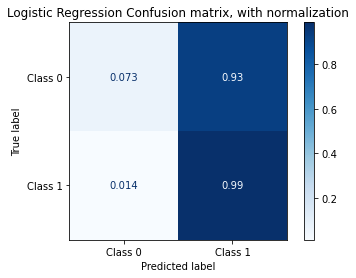

In [40]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization')

['دوربین', 'نیز', 'ای', 'کاملا', 'اینکه', 'هاي', 'تو', 'وجود', 'واقعا', 'نمایش']


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Word')

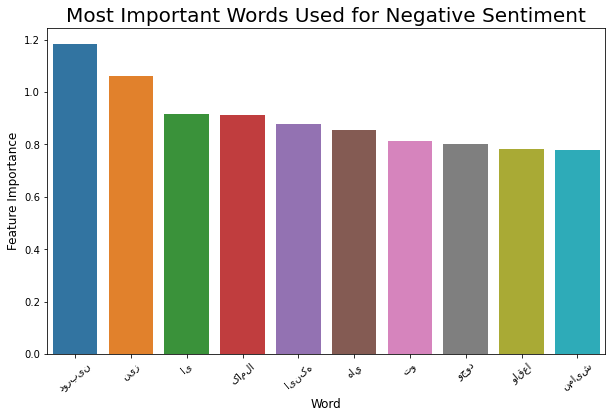

In [44]:
TOP = 10

feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

top_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-TOP-1, -1)]]

print(top_pos_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_pos_w, feature_importance[sorted_idx[range(-1,-TOP-1, -1)]])
plt.title("Most Important Words Used for Negative Sentiment", fontsize=20)
x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize=12)

['کیفیت', 'خوشمزه', 'اصلا', 'ارسال', 'خوش', 'بود', 'تازه', 'موقع', 'بندی', 'همیشه']


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 0, 'Word')

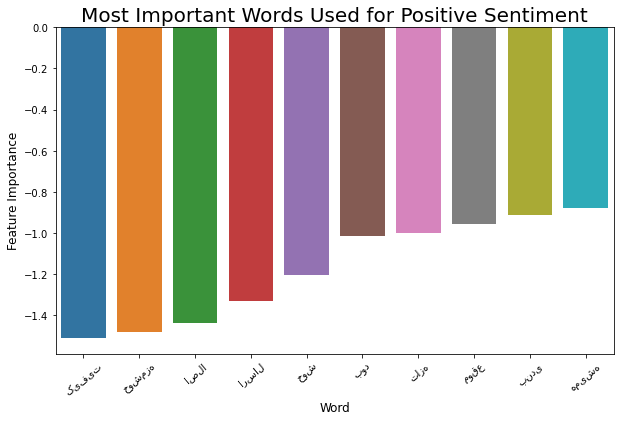

In [45]:
TOP = 10

sorted_idx = np.argsort(feature_importance)

top_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:TOP]]

print(top_neg_w)

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_neg_w, feature_importance[sorted_idx[:TOP]])
plt.title("Most Important Words Used for Positive Sentiment", fontsize=20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize=12)

In [46]:
explainer = shap.LinearExplainer(lr, train_feature_set, feature_dependence="independent")
shap_values = explainer.shap_values(test_feature_set)
X_test_array = test_feature_set.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


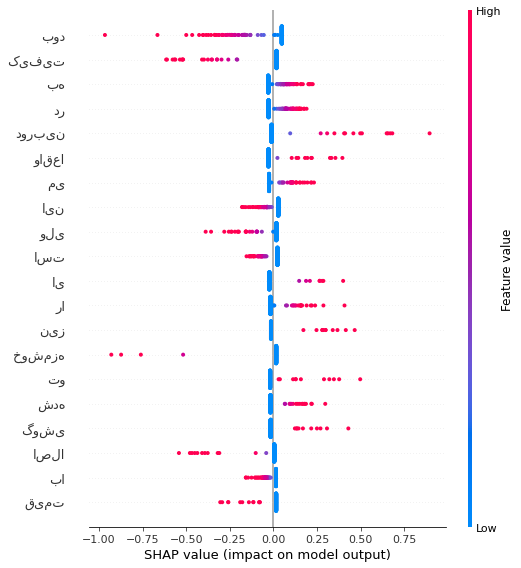

In [47]:
shap.summary_plot(shap_values, X_test_array, feature_names=tfidf_v.get_feature_names())